# Genomic analysis of a parasite invasion: colonization of the New World by the blood fluke, Schistosoma mansoni 

Roy Nelson Platt II*, Frédéric D. Chevalier*, Winka Le Clec'h, Marina McDew-White, Philip T. LoVerde, Rafael Ramiro de Assis, Guilherme Oliveira, Safari Kinunghi, Anouk Gouvras, Bonnie Webster, Joanne Webster, Aidan Emery, David Rollinson, Timothy J. Anderson

# Finding regions under selelection using interpopulation test

use the `sch_man_nwinvasion-pcadapt` conda env

In [ ]:
import os
from pathlib import Path
import pandas as pd
import pybedtools

%load_ext rpy2.ipython

# pcadapt

In [ ]:
proj_dir    = "/master/nplatt/sch_man_nwinvasion"
results_dir = "{}/results".format(proj_dir)

In [ ]:
os.chdir(proj_dir)
if not os.path.isdir("{}/pcadapt".format(results_dir)):
    os.mkdir("{}/ld".format(results_dir))
    
os.chdir("{}/pcadapt".format(results_dir))

Steps to prep data
 - Get a copy of the phased beagle file (for the imputations, not phasing)
 - remove outgroups
 - keep maf05
 - LD filter

In [ ]:
%%bash 

#remove the samples we aren't interested in
vcf-query -l ../phasing/auto_beagle.vcf \
    | grep -v rep \
    | grep -e Sm.BR -e Sm.SN -e Sm.NE \
    >ingroup_samples.list

#maf filter and only keep ingroups
vcftools \
    --vcf ../phasing/auto_beagle.vcf \
    --keep ingroup_samples.list \
    --maf 0.05 \
    --recode \
    --recode-INFO-all \
    --stdout \
    >auto_beagle_maf05_ingroups.vcf
 
#go ahead and ld filter the snot of out the file as well
plink \
    --vcf auto_beagle_maf05_ingroups.vcf \
    --allow-extra-chr \
    --double-id \
    --indep-pairwise 1000 5 0.20 \
    --out ld_pruned

# vcftools \
#     --vcf auto_beagle_maf05_ingroups.vcf \
#     --exclude auto_beagle_maf05_ingroups_ld_filtered.prune.out \
#     --recode \
#     --recode-INFO-all \
#     --stdout \
#     --thin 10000 \
#     >auto_beagle_maf05_ingroups_ld_filtered.vcf



PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ld_pruned.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --indep-pairwise 1000 5 0.20
  --out ld_pruned
  --vcf auto_beagle_maf05_ingroups.vcf

128540 MB RAM detected; reserving 64270 MB for main workspace.
--vcf: ld_pruned-temporary.bed + ld_pruned-temporary.bim +
ld_pruned-temporary.fam written.
21913 variants loaded from .bim file.
80 people (0 males, 0 females, 80 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ld_pruned.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 80 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
21913 variants and 80 peopl


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../phasing/auto_beagle.vcf
	--keep ingroup_samples.list
	--recode-INFO-all
	--maf 0.05
	--recode
	--stdout

Keeping individuals in 'keep' list
After filtering, kept 80 out of 155 Individuals
Outputting VCF file...
After filtering, kept 21913 out of a possible 475081 Sites
Run Time = 10.00 seconds


In [27]:
%%bash

#ld filter even more
plink \
    --vcf auto_beagle_maf05_ingroups.vcf \
    --allow-extra-chr \
    --double-id \
    --make-bed \
    --out nw_se_ne_auto_beagle_maf05



PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to nw_se_ne_auto_beagle_maf05.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --make-bed
  --out nw_se_ne_auto_beagle_maf05
  --vcf auto_beagle_maf05_ingroups.vcf

128540 MB RAM detected; reserving 64270 MB for main workspace.
--vcf: nw_se_ne_auto_beagle_maf05-temporary.bed +
nw_se_ne_auto_beagle_maf05-temporary.bim +
nw_se_ne_auto_beagle_maf05-temporary.fam written.
21913 variants loaded from .bim file.
80 people (0 males, 0 females, 80 ambiguous) loaded from .fam.
Ambiguous sex IDs written to nw_se_ne_auto_beagle_maf05.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 80 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737

Use the `pcadapt` R package to analyse the data

In [28]:
%%R

#install.packages("pcadapt")
library(pcadapt)

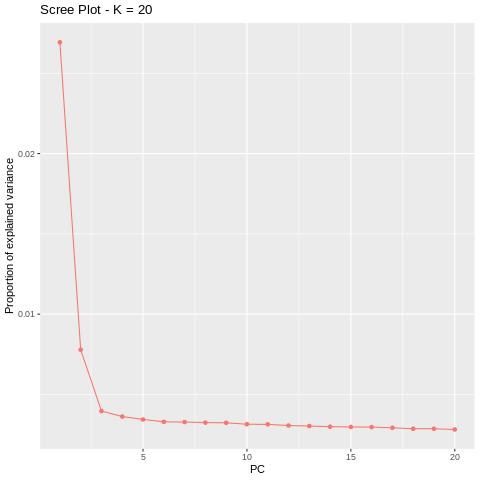

In [28]:
%%R

#check the number of populations (ks)
path_to_file <- "nw_se_ne_auto_beagle_maf05.bed"
plink_file   <- read.pcadapt(path_to_file, type = "bed")

x <- pcadapt( input       = plink_file, 
              K           = 20, 
              LD.clumping = list(size = 100, thr = 0.2)
            )

png(filename   = "screeplot.png");
plot(x, option = "screeplot")
dev.off()

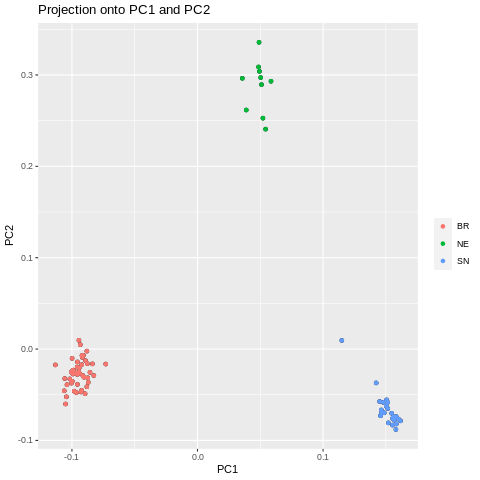

In [29]:
%%R

#check to see if that number of PCs differentiates the populations

# With integers
pop_list <- as.factor(substr(indNames(genind), 4, 5))


png(filename = "pcadapt_scores_pc1-2.png")
plot(x, 
     option = "scores", 
     pop    = pop_list)
dev.off()

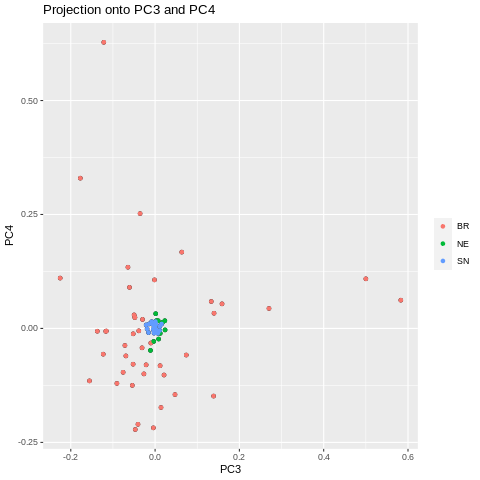

In [30]:
%%R

#check other PCs just to see

#png(filename = "pcadapt_scores_pc3-4.png")
plot(x, 
     option = "scores", 
     i      = 3, 
     j      = 4, 
     pop    = pop_list)
#dev.off()

[1] 442


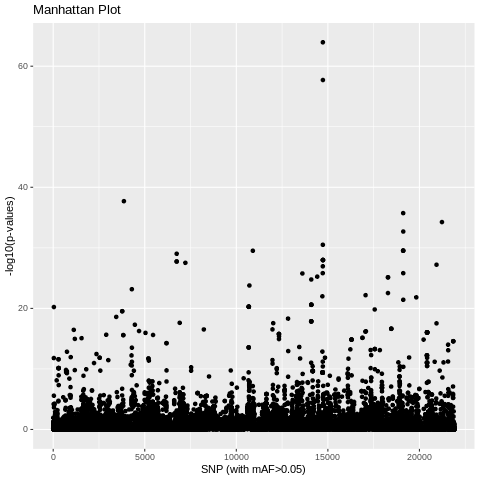

In [31]:
%%R

#now filter and re-calc pcadapt values with the appropriate K
x <- pcadapt( input       = plink_file, 
              K           = 2, 
              LD.clumping = list(size = 100, thr = 0.2)
            )

#summary(x)

#plot across the genome
png(filename = "pcadapt_manhattan_k2.png")
plot(x , 
     option = "manhattan")
dev.off()

#adjsut for mutliple tests
padj  <- p.adjust( x$pvalues,
                   method="bonferroni" )
alpha <- 0.05

#how many outliers
outliers <- which(padj < alpha)
length(outliers)

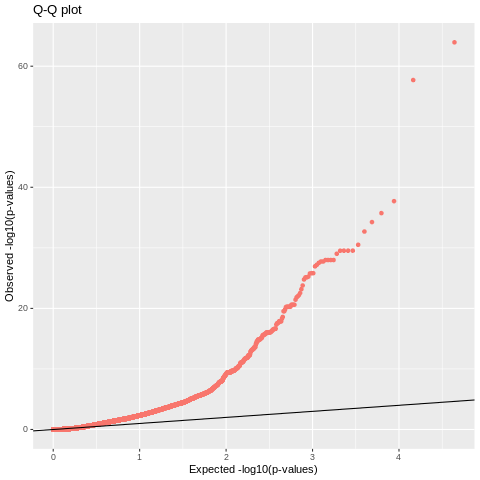

In [32]:
%%R

png(filename = "pcadapt_qq_k2.png")
plot( x, 
      option = "qqplot")
dev.off()

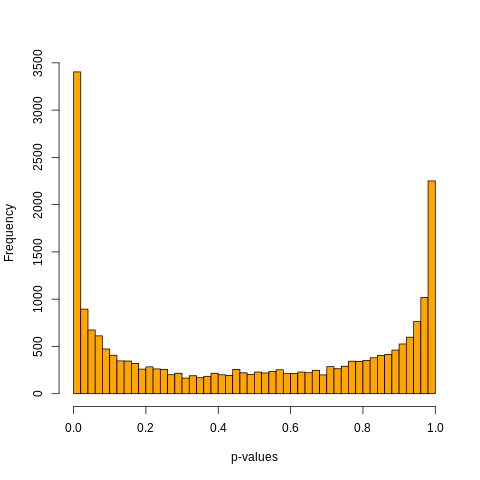

In [33]:
%%R
#plot the pvalue distribution
png(filename = "pcadapt_pvalues_k2.png")
hist(x$pvalues, 
     xlab   = "p-values", 
     main   = NULL, 
     breaks = 50, 
     col    = "orange")
dev.off()

In [35]:
%%R

#create a table with all of the output data

#cols:
#pos, chrom, chi2, pvalues, corrected-p, -log10pvalue, component, outlier(T/F)

pos   <- getPOS(vcfr)
chrom <- getCHROM(vcfr)
stat  <- x$stat
chi2  <- x$chi2.stat
pval  <- x$pvalues
padj  <- padj
logp  <- -log10(padj)
sigs  <-c(rep("FALSE", length(padj)))

for (idx in outliers) {
    sigs[idx]="TRUE"
}

comps<-c(rep("NaN", length(padj)))

snp_pc<-get.pc(x, outliers)

for (idx in snp_pc$SNP) {
    comps[idx] = snp_pc$PC[snp_pc$SNP==idx]
}

het < -my_fst$He[c(TRUE, FALSE)]
fst < -my_fst$FSTNoCorr[c(TRUE, FALSE)]

df=data.frame( chrom, 
               pos, 
               stat, 
               chi2, 
               pval, 
               padj, 
               logp, 
               sigs, 
               comps, 
               fst, 
               het, 
               stringsAsFactors=TRUE )

write.csv( df, 
           "pcadapt.csv", 
           row.names = FALSE, 
           quote=FALSE )
head(df, 20)


     chrom     pos       stat      chi2       pval padj logp  sigs comps
1  SM_V7_1  302288  1.7071525 0.9438588 0.62379755    1    0 FALSE   NaN
2  SM_V7_1  705322  1.3286242 0.7345762 0.69261006    1    0 FALSE   NaN
3  SM_V7_1  705340  2.0497358 1.1332679 0.56743222    1    0 FALSE   NaN
4  SM_V7_1 1060362  0.9230204 0.5103240 0.77479096    1    0 FALSE   NaN
5  SM_V7_1 1060390 16.2750582 8.9982336 0.01111881    1    0 FALSE   NaN
6  SM_V7_1 1197094  4.4147546 2.4408511 0.29510456    1    0 FALSE   NaN
7  SM_V7_1 1197521  7.7140729 4.2649943 0.11854091    1    0 FALSE   NaN
8  SM_V7_1 1197568  7.7140729 4.2649943 0.11854091    1    0 FALSE   NaN
9  SM_V7_1 1197961 10.3655249 5.7309420 0.05695630    1    0 FALSE   NaN
10 SM_V7_1 1198172  9.8798071 5.4623960 0.06514120    1    0 FALSE   NaN
11 SM_V7_1 1198177  9.8798071 5.4623960 0.06514120    1    0 FALSE   NaN
12 SM_V7_1 1198211 10.6397937 5.8825811 0.05279755    1    0 FALSE   NaN
13 SM_V7_1 1208493 10.0245253 5.5424085 0.06258659 

In [41]:
#now switch back to python for further analyses
df = pd.read_csv( "pcadapt.csv", 
                  sep="," )

In [45]:
#fst at sig sites
df.loc[df["sigs"] == True]["fst"].mean()

0.5440953615002239

In [46]:
#fst at non-sig sites
df.loc[df["sigs"] != True]["fst"].mean()

0.19512604680836637

## merge pcadapt sites into 1/3Mb regions


In [6]:
#convert pcadapt to bed
df = pd.read_csv( "pcadapt.csv", 
                  sep="," )
df

,chrom,pos,stat,chi2,pval,padj,logp,sigs,comps,fst,het
0,SM_V7_1,302288,1.707152,0.943859,0.623798,1.0,0.0,False,NaN,0.000213,0.499922
1,SM_V7_1,705322,1.328624,0.734576,0.692610,1.0,0.0,False,NaN,0.001793,0.095000
2,SM_V7_1,705340,2.049736,1.133268,0.567432,1.0,0.0,False,NaN,0.019065,0.117188
3,SM_V7_1,1060362,0.923020,0.510324,0.774791,1.0,0.0,False,NaN,0.094908,0.409687
4,SM_V7_1,1060390,16.275058,8.998234,0.011119,1.0,0.0,False,NaN,0.073177,0.420000
...,...,...,...,...,...,...,...,...,...,...,...
21908,SM_V7_7,19000002,2.682516,1.483122,0.476370,1.0,0.0,False,NaN,0.358452,0.447188
21909,SM_V7_7,19000008,5.928768,3.277926,0.194181,1.0,0.0,False,NaN,0.501766,0.488750
21910,SM_V7_7,19009311,0.642314,0.355126,0.837308,1.0,0.0,False,NaN,0.046552,0.199687
21911,SM_V7_7,19009392,2.247127,1.242403,0.537299,1.0,0.0,False,NaN,0.010241,0.117188


In [15]:
#create a bedfile from the df
sig_df = df.loc[df["sigs"] == True]
chroms = sig_df["chrom"]
start  = sig_df["pos"]
stop   = sig_df["pos"]+1

#make the data and data frame
d = {"chrom": chroms, "start": start, "stop": stop}
bed_df = pd.DataFrame(d)

#save to csv
bed_df.to_csv("pcadapt.bed", header=False, index=False, sep="\t")

In [ ]:
#merge sig sites within 1/3 mb of one another.
buffer = 333_333

pcadapt_snps_bed = pybedtools.BedTool("pcadapt.bed")
pcadapt_int_bed  = pcadapt_snps_bed.merge(d=buffer)

#save the bed file
pcadapt_int_bed.saveas("pcadapt_regions.bed")